In [5]:
require 'set'

class Value
  attr_accessor :label, :gradient, :data, :_backward
  attr_reader :antecedents, :operation

  def initialize(data, antecedents: [], operation: '', label: "")
    @data = data
    @antecedents = Set.new(antecedents)
    @operation = operation
    @label = label
    @_backward = -> {}
    
    @gradient = 0.0
  end

  def +(addend)
    sum = @data + addend.data
    addends = [self, addend]
    out = Value.new(sum, antecedents: addends, operation: '+')
    
    _backward = -> {
      @gradient += 1.0 * out.gradient
      addend.gradient += 1.0 * out.gradient
    }
    out._backward = _backward

    return out
  end
 
  def *(multiplier)
    product = @data * multiplier.data
    multiplicands = [self, multiplier]
    out = Value.new(product, antecedents: multiplicands, operation: "*")

    _backward = -> {
      @gradient += multiplier.data * out.gradient
      multiplier.gradient += @data * multiplier.gradient
    }
    out._backward = _backward

    return out
  end
  
  def tanh
    activation = (Math.exp(2 * @data) - 1) / (Math.exp(2 * @data) + 1)
    out = Value.new(activation, antecedents: [self], operation: "tanh")

    _backward = -> {
      @gradient = (1 - activation**2) * out.gradient
    }
    out._backward = _backward

    return out
  end

  def backward
    topological_order = []
    visited = Set.new
    build_topological_order = ->(vertex) {
      unless visited.include? vertex
        visited << vertex
        vertex.antecedents.each do |antecedent|
          build_topological_order.call(antecedent)
        end
        topological_order << vertex
      end
    }
    build_topological_order.call(self)

    self.gradient = 1.0
    
    topological_order.reverse.each do |node|
      node._backward.call
    end
  end

private
  def to_s
    puts %[Value(data: #{@data}, antecedents: #{@antecedents.map(&:data)})]
  end
end


:to_s

In [2]:
require 'ruby-graphviz'

def trace(root)
  nodes, edges = Set.new, Set.new
  build = -> (vertex) {
    unless nodes.include?(vertex)
      nodes << vertex
      vertex.antecedents.each do |antecedent|
        edges << [antecedent, vertex]
        build.call(antecedent)
      end
    end
  }
  build.call(root)
  return nodes, edges
end

def draw_dot(root)
  dot = GraphViz.new(:G, :rankdir => "LR", :type => :digraph)

  nodes, edges = trace(root)

  nodes.each do |node|
    uid = node.object_id.to_s
    dot.add_nodes(uid, label: "{ %s | data %0.4f | gradient %0.4f }" % [node.label, node.data, node.gradient] , shape: "record")
    if !node.operation.empty?
      operation_name = uid + node.operation
      dot.add_nodes(operation_name, label: node.operation, shape: "circle")
      dot.add_edges(operation_name, uid)
    end
  end
  
  edges.each do |node1, node2|
    origin_name = node1.object_id.to_s
    destination_name = node2.object_id.to_s + node2.operation
    dot.add_edges(origin_name, destination_name)
  end
  
  svg_string = dot.output(:svg => String)
  IRuby.display IRuby.svg(svg_string)
end


:draw_dot

In [3]:
a = Value.new(2.0, label: "a")
b = Value.new(-3.0, label: "b")
c = Value.new(10.0, label: "c")
d = a * b
d.label = "d"
e = d + c
e.label = "e"
f = Value.new(-2.0, label: "f")
loss = e * f; loss.label = "loss" # loss function 

# Back propagation:
# Derivative of the value L with respect to each of e, f, d, c, b, a
# - calculate the derivative of each value with respect to L
# - the operator effects the formula used to calculate the derivative


NoMethodError: undefined method `_backward=' for #<#<Class:0x00000001129de938>::Value:0x0000000112479650 @data=-6.0, @antecedents=#<Set: {#<#<Class:0x00000001129de938>::Value:0x0000000112479740 @data=2.0, @antecedents=#<Set: {}>, @operation="", @label="a", @_backward=#<Proc:0x0000000112a54bd8 (irb):11 (lambda)>, @gradient=0.0>, #<#<Class:0x00000001129de938>::Value:0x00000001124796f0 @data=-3.0, @antecedents=#<Set: {}>, @operation="", @label="b", @_backward=#<Proc:0x0000000112a54a20 (irb):11 (lambda)>, @gradient=0.0>}>, @operation="*", @label="", @_backward=#<Proc:0x0000000112a54638 (irb):11 (lambda)>, @gradient=0.0>

In [ ]:
# derivitae of L with respect to L
# if I change L by h, what is the rate of change of L. It's 
loss.gradient = 1.0
a.gradient = 6.0
b.gradient = -4.0
c.gradient = -2.0
f.gradient = 4.0
e.gradient = -2
d.gradient = -2

a.data += 0.001 * a.gradient
b.data += 0.001 * b.gradient
c.data += 0.001 * c.gradient
f.data += 0.001 * f.gradient

d = a*b
e = d + c
loss = e * f

puts loss.data

draw_dot(loss)

In [ ]:

def lol
  h = 0.001

  a = Value.new(2.0, label: "a")
  b = Value.new(-3.0, label: "b")
  c = Value.new(10.0, label: "c")
  d = a * b
  d.label = "d"
  e = d + c
  e.label = "e"
  f = Value.new(-2.0, label: "f")
  lL = e * f; lL.label = "L" # loss function 
  lL1 = lL.data

  a = Value.new(2.0, label: "a")
  b = Value.new(-3.0, label: "b")
  c = Value.new(10.0, label: "c")
  d = a * b
  d.label = "d"
  e = d + c
  # e.data += h
  e.label = "e"
  f = Value.new(-2.0, label: "f")
  lL = e * f; lL.label = "L" # loss function 
  lL2 = lL.data

  puts ((lL2 - lL1)/h)

end

lol()

In [ ]:
# inputs x1,x2
x1 = Value.new(2.0, label: 'x1')
x2 = Value.new(0.0, label: 'x2')
# weights w1,w2
w1 = Value.new(-3.0, label: 'w1')
w2 = Value.new(1.0, label: 'w2')
# bias of the neuron
b = Value.new(6.8813735870195432, label: 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
draw_dot(o)

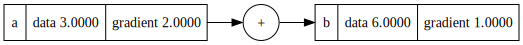

In [7]:
a = Value.new(3.0, label: "a")
b = a + a; b.label = 'b'

b.backward
draw_dot(b)


In [ ]:
o.gradient = 1.0
o.backward.call
n.backward.call

b.backward.call
x1w1x2w2.backward.call
x1w1.backward.call
x2w2.backward.call
# o.gradient = 1.0
# n.gradient = 0.5
# b.gradient = 0.5
# x1w1x2w2.gradient = 0.5
# x1w1.gradient = 0.5
# x2w2.gradient = 0.5
# x2.gradient = w2.data * x2w2.gradient
# w2.gradient = x2.data * x2w2.gradient
# x1.gradient = w1.data * x1w1.gradient
# w1.gradient = x1.data * x1w1.gradient

